In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Small
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Tambahkan deskripsi fitur untuk mengurai TFRecord
feature_description = {
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
}

# Define fungsi untuk mengurai file TFRecord dan mendapatkan nama 'class'
def parse_tfrecord_for_class_names(tfrecord):
    example = tf.io.parse_single_example(tfrecord, feature_description)
    class_text = tf.sparse.to_dense(example['image/object/class/text'])
    return class_text


In [ ]:
# Path ke berkas file TFRecord
train_path = '/content/drive/MyDrive/KalorikuApp/makanan_indonesia.v5i.tfrecord/train/makanan.tfrecord'
valid_path = '/content/drive/MyDrive/KalorikuApp/makanan_indonesia.v5i.tfrecord/valid/makanan.tfrecord'
test_path = '/content/drive/MyDrive/KalorikuApp/makanan_indonesia.v5i.tfrecord/test/makanan.tfrecord'

# Buat TFRecordDataset
raw_dataset = tf.data.TFRecordDataset(valid_path)


In [ ]:
# Kumpulkan nama 'class' dari dataset
class_names_set = set()

for raw_record in raw_dataset:
    class_text = parse_tfrecord_for_class_names(raw_record)
    for class_name in class_text.numpy():
        class_names_set.add(class_name.decode('utf-8'))

# Konversikan menjadi 'sorted list' untuk konsistensi indeks
class_names_list = sorted(list(class_names_set))
print("Class names:", class_names_list)
num_classes = len(class_names_list)
print("Number of classes:", num_classes)

Class names: ['air', 'anggur', 'apel', 'ayam', 'bakso', 'bakwan', 'batagor', 'bubur', 'burger', 'cakwe', 'capcay', 'crepes', 'cumi', 'donat', 'durian', 'es_krim', 'fu_yung_hai', 'gudeg', 'ikan', 'jeruk', 'kacang', 'kebab', 'kentang', 'kerupuk', 'kopi']
Number of classes: 25


In [ ]:
def parse_tfrecord(tfrecord):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }

    try:
        example = tf.io.parse_single_example(tfrecord, feature_description)
        image = tf.image.decode_jpeg(example['image/encoded'], channels=3)
        image = tf.image.resize(image, [416, 416])
        label = tf.sparse.to_dense(example['image/object/class/label'])[0] - 1
        return image, label
    except Exception as e:
        print(f"Error processing record: {e}")
        return None, None


In [ ]:
# Define Fungsi augmentasi dan preprocessing
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    return image, label

def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)  # Pastikan label dalam bentuk integer
    return image, label


In [ ]:
# Load dataset untuk data train, validation, dan test
train_dataset = tf.data.TFRecordDataset(train_path).map(parse_tfrecord)
valid_dataset = tf.data.TFRecordDataset(valid_path).map(parse_tfrecord)
test_dataset = tf.data.TFRecordDataset(test_path).map(parse_tfrecord)

# Terapkan augmentasi hanya pada dataset training
# Menambahkan .prefetch(tf.data.experimental.AUTOTUNE) untuk meningkatkan performa input pipeline
train_dataset = train_dataset.map(preprocess_image).map(augment).shuffle(1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.map(preprocess_image).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image).batch(1).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Periksa bentuk dari dataset
for images, labels in train_dataset.take(1):
    print(f'Image batch shape: {images.shape}')
    print(f'Label batch shape: {labels.shape}')

Image batch shape: (32, 416, 416, 3)
Label batch shape: (32,)


In [ ]:
# Load Model MobileNetV2 dengan 'pretrained weights'
base_model = MobileNetV2(weights='imagenet',
                         include_top=False,
                         input_shape=(416, 416, 3))
base_model.trainable = False   # Freeze model dasar
# Tambahkan custom layers diatas model dasar
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes,
                    activation='softmax',
                    kernel_regularizer=l2(0.01))(x)
# Buat model akhir
model = Model(inputs=base_model.input, outputs=predictions)

# Compile 'the model'
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 208, 208, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 208, 208, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [ ]:
# Atur callback
early_stopping = EarlyStopping(
    patience=10,
    monitor='val_loss',
    restore_best_weights=True,
)

# Train 'the model'
history = model.fit(
    train_dataset,
    epochs=200,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/200
14/14 - 19s - loss: 11.3069 - accuracy: 0.0650 - val_loss: 10.8055 - val_accuracy: 0.0976 - 19s/epoch - 1s/step
Epoch 2/200
14/14 - 4s - loss: 11.0315 - accuracy: 0.0441 - val_loss: 10.5716 - val_accuracy: 0.1626 - 4s/epoch - 305ms/step
Epoch 3/200
14/14 - 4s - loss: 10.7377 - accuracy: 0.0742 - val_loss: 10.3587 - val_accuracy: 0.2602 - 4s/epoch - 280ms/step
Epoch 4/200
14/14 - 4s - loss: 10.5422 - accuracy: 0.0696 - val_loss: 10.1428 - val_accuracy: 0.3252 - 4s/epoch - 282ms/step
Epoch 5/200
14/14 - 5s - loss: 10.2949 - accuracy: 0.1323 - val_loss: 9.9410 - val_accuracy: 0.4228 - 5s/epoch - 359ms/step
Epoch 6/200
14/14 - 4s - loss: 10.0454 - accuracy: 0.1624 - val_loss: 9.7451 - val_accuracy: 0.4715 - 4s/epoch - 275ms/step
Epoch 7/200
14/14 - 4s - loss: 9.8451 - accuracy: 0.2135 - val_loss: 9.5515 - val_accuracy: 0.5366 - 4s/epoch - 279ms/step
Epoch 8/200
14/14 - 4s - loss: 9.6980 - accuracy: 0.2506 - val_loss: 9.3663 - val_accuracy: 0.5691 - 4s/epoch - 280ms/step
Epoch 9

In [ ]:
# Fine-tuning: Unfreeze beberapa layers dan lanjutkan training
base_model.trainable = True
fine_tune_at = len(base_model.layers) // 2

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile ulang 'the model'
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

# Lanjutkan training dengan fine-tuning
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/100
14/14 - 22s - loss: 2.6625 - accuracy: 0.5708 - val_loss: 1.5821 - val_accuracy: 0.9106 - 22s/epoch - 2s/step
Epoch 2/100
14/14 - 5s - loss: 2.3529 - accuracy: 0.6404 - val_loss: 1.5733 - val_accuracy: 0.9024 - 5s/epoch - 325ms/step
Epoch 3/100
14/14 - 5s - loss: 2.1888 - accuracy: 0.7030 - val_loss: 1.5717 - val_accuracy: 0.8943 - 5s/epoch - 370ms/step
Epoch 4/100
14/14 - 5s - loss: 2.0611 - accuracy: 0.7123 - val_loss: 1.5723 - val_accuracy: 0.8780 - 5s/epoch - 327ms/step
Epoch 5/100
14/14 - 4s - loss: 1.9189 - accuracy: 0.7726 - val_loss: 1.5719 - val_accuracy: 0.8862 - 4s/epoch - 312ms/step
Epoch 6/100
14/14 - 6s - loss: 1.8078 - accuracy: 0.8144 - val_loss: 1.5722 - val_accuracy: 0.8780 - 6s/epoch - 393ms/step
Epoch 7/100
14/14 - 4s - loss: 1.7350 - accuracy: 0.8190 - val_loss: 1.5760 - val_accuracy: 0.8699 - 4s/epoch - 308ms/step
Epoch 8/100
14/14 - 5s - loss: 1.6889 - accuracy: 0.8654 - val_loss: 1.5813 - val_accuracy: 0.8699 - 5s/epoch - 338ms/step
Epoch 9/100
14/14

In [ ]:
# Evaluasi model pada data tes
test_loss, test_acc = model.evaluate(test_dataset)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

62/62 [==============================] - 2s 12ms/step - loss: 1.6369 - accuracy: 0.8871
Test Accuracy: 0.8870967626571655
Test Loss: 1.6369400024414062


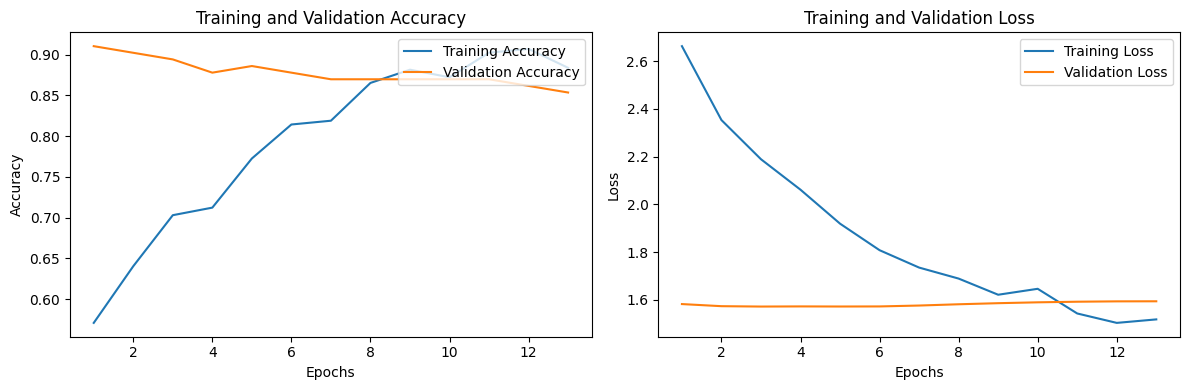

In [ ]:
# Plot akurasi dan loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Sesuaikan ukuran gambar agar tidak terlalu tinggi
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

Prediction

62/62 [==============================] - 2s 8ms/step


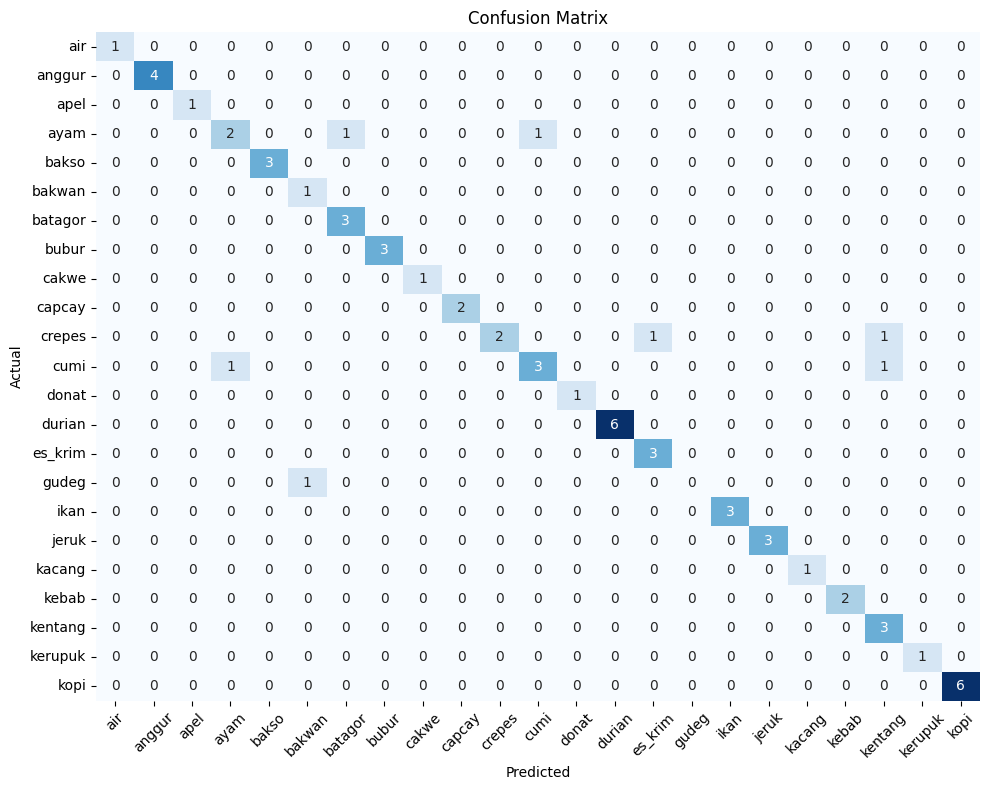

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Daftar nama makanan 23 value karena dalam dataset hanya ada 23 (burger dan fuyunghai tidak ada)
class_names = ['air', 'anggur', 'apel', 'ayam', 'bakso', 'bakwan', 'batagor', 'bubur', 'cakwe', 'capcay', 'crepes', 'cumi', 'donat', 'durian', 'es_krim', 'gudeg', 'ikan', 'jeruk', 'kacang', 'kebab', 'kentang', 'kerupuk', 'kopi']

predictions = np.argmax(model.predict(test_dataset), axis=1)
true_labels = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)

# Membuat confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)

# Mengubah label di sumbu x dan y menjadi nama makanan
tick_labels = [class_names[i] for i in range(len(class_names))]
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=tick_labels, rotation=45)
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=tick_labels, rotation=0)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.tight_layout()
plt.show()


Classification report dengan valid dataset

In [ ]:
from sklearn.metrics import classification_report

predictions = np.argmax(model.predict(valid_dataset), axis=1)
true_labels = np.concatenate([y.numpy() for _, y in valid_dataset], axis=0)
true_labels = np.squeeze(true_labels).astype(int)

class_names = ['air', 'anggur', 'apel', 'ayam', 'bakso', 'bakwan', 'batagor', 'bubur', 'burger', 'cakwe', 'capcay', 'crepes', 'cumi', 'donat', 'durian', 'es_krim', 'fu_yung_hai', 'gudeg', 'ikan', 'jeruk', 'kacang', 'kebab', 'kentang', 'kerupuk', 'kopi']

unique_classes = np.unique(true_labels)

# Menyaring class_names untuk kelas-kelas yang ada dalam unique_classes
filtered_class_names = [class_names[class_idx] for class_idx in unique_classes]

clr = classification_report(true_labels, predictions, labels=unique_classes, target_names=filtered_class_names)

# Print classification report
print("Classification Report:\n----------------------\n", clr)


4/4 [==============================] - 1s 153ms/step
Classification Report:
----------------------
               precision    recall  f1-score   support

         air       1.00      0.90      0.95        10
      anggur       1.00      1.00      1.00         7
        apel       1.00      1.00      1.00         7
        ayam       0.85      0.92      0.88        12
       bakso       1.00      1.00      1.00         2
      bakwan       0.80      0.80      0.80         5
     batagor       0.67      0.86      0.75         7
       bubur       1.00      0.75      0.86         4
      burger       1.00      1.00      1.00         6
       cakwe       1.00      1.00      1.00         6
      capcay       1.00      1.00      1.00         4
      crepes       1.00      0.50      0.67         4
        cumi       1.00      0.33      0.50         3
       donat       1.00      0.88      0.93         8
      durian       1.00      1.00      1.00         3
     es_krim       1.00      0.86  

Classification report dengan Test dataset

Test dataset hanya memiliki 23 uniqe value, tidak ada:
- burger       
- fu_yung_hai       

In [ ]:
from sklearn.metrics import classification_report

predictions = np.argmax(model.predict(test_dataset), axis=1)

# Mendapatkan true label dari test_dataset
true_labels = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
true_labels = np.squeeze(true_labels).astype(int)

class_names = ['air', 'anggur', 'apel', 'ayam', 'bakso', 'bakwan', 'batagor', 'bubur', 'burger', 'cakwe', 'capcay', 'crepes', 'cumi', 'donat', 'durian', 'es_krim', 'fu_yung_hai', 'gudeg', 'ikan', 'jeruk', 'kacang', 'kebab', 'kentang', 'kerupuk', 'kopi']

unique_classes = np.unique(true_labels)
filtered_class_names = [class_names[class_idx] for class_idx in unique_classes]

clr = classification_report(true_labels, predictions, labels=unique_classes, target_names=filtered_class_names)

# Print classification report
print("Classification Report:\n----------------------\n", clr)


62/62 [==============================] - 0s 7ms/step
Classification Report:
----------------------
               precision    recall  f1-score   support

         air       1.00      1.00      1.00         1
      anggur       1.00      1.00      1.00         4
        apel       1.00      1.00      1.00         1
        ayam       0.67      0.50      0.57         4
       bakso       1.00      1.00      1.00         3
      bakwan       0.50      1.00      0.67         1
     batagor       0.75      1.00      0.86         3
       bubur       1.00      1.00      1.00         3
       cakwe       1.00      1.00      1.00         1
      capcay       1.00      1.00      1.00         2
      crepes       1.00      0.50      0.67         4
        cumi       0.75      0.60      0.67         5
       donat       1.00      1.00      1.00         1
      durian       1.00      1.00      1.00         6
     es_krim       0.75      1.00      0.86         3
       gudeg       0.00      0.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_save_path = '/content/drive/My Drive/KalorikuApp/food_detection_model.h5'
model.save(model_save_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Simpan model
model_save_path = '/content/drive/MyDrive/KalorikuApp/food_detection_model'
model.save(model_save_path, save_format='tf')

1/1 [==============================] - 3s 3s/step


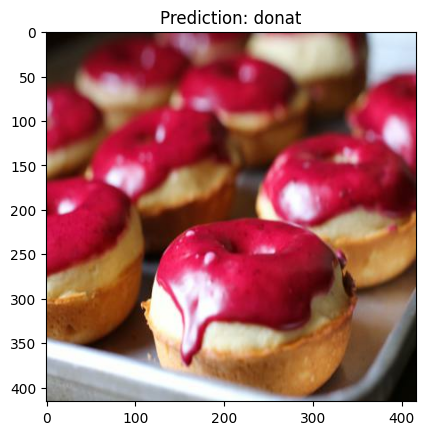

In [ ]:
import numpy as np

# Path ke model .h5 atau SavedModel
model_path = '/content/drive/MyDrive/KalorikuApp/food_detection_model.h5'

# Memuat model Keras
model = tf.keras.models.load_model(model_path)

batch_size = 1

class_names = ['air', 'anggur', 'apel', 'ayam', 'bakso', 'bakwan', 'batagor', 'bubur', 'burger', 'cakwe', 'capcay', 'crepes', 'cumi', 'donat', 'durian', 'es_krim', 'fu_yung_hai', 'gudeg', 'ikan', 'jeruk', 'kacang', 'kebab', 'kentang', 'kerupuk', 'kopi']

# Prediksi gambar dari dataset
for images, labels in test_dataset.take(1):
    # Memanggil fungsi predict untuk memperoleh prediksi
    predictions = model.predict(images)

    # Menampilkan hasil prediksi dan gambar yang diprediksi
    for i in range(batch_size):
        plt.imshow(images[i].numpy())

        # Mendapatkan label yang diprediksi
        predicted_label_index = np.argmax(predictions[i])
        predicted_label = class_names[predicted_label_index]

        plt.title(f'Prediction: {predicted_label}')
        plt.show()

Mencoba Exporting pakai TFLite

In [ ]:
# Pilih mode optimisasi
mode = "Speed"

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
model_save_path = '/content/drive/MyDrive/KalorikuApp/food_detection_model'
converter = tf.lite.TFLiteConverter.from_saved_model(model_save_path)

# Atur optimisasi
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Panggil converter untuk menghasilkan model TFLite
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)


In [ ]:
import pathlib

tflite_model_file = pathlib.Path('/content/drive/My Drive/KalorikuApp/food_detection_model.tflite')
tflite_model_file.write_bytes(tflite_model)

3170520

Test the Model with TFLite Interpreter

In [ ]:
import tensorflow as tf
# Load Model TFLite dan allocate tensor
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/KalorikuApp/food_detection_model.tflite')
interpreter.allocate_tensors()

# Dapatkan input dan output tensors.
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
from tqdm import tqdm
# Kumpulkan hasil acak dari 'sampled test images'
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_dataset.take(25)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))

    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

25it [00:02,  9.73it/s]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
class_names = ['air', 'anggur', 'apel', 'ayam', 'bakso', 'bakwan', 'batagor', 'bubur', 'burger', 'cakwe', 'capcay', 'crepes', 'cumi', 'donat', 'durian', 'es_krim', 'fu_yung_hai', 'gudeg', 'ikan', 'jeruk', 'kacang', 'kebab', 'kentang', 'kerupuk', 'kopi']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    print(type(predicted_label), type(true_label))

    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)



<class 'numpy.int64'> <class 'numpy.int32'>


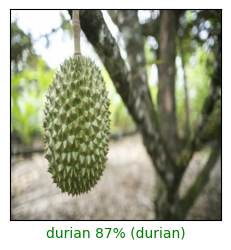

In [ ]:
#@title Visualize the outputs { run: "auto" }
index = 2 #@param {type:"slider", min:0, max:24, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()